In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

In [2]:
run ../util/setupConsole_su

In [3]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [4]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

In [5]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [6]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
N_gridcells = np.where((land_sea_mask.lsm[0,:,:].values.reshape([lat.size*lon.size]))>0)[0].size

In [7]:
# for y, year in enumerate(range(1981, 2019+1)):
#     os.rename('heat_wave_days/era5_cold_wave_days_%d.dat'%year, 'heat_wave_days/era5_t_min_wave_days_%d.dat'%year)

In [8]:
with open('%s/cropped_area/crop_land_regrid_era5.dat'%(dirAg6), 'rb') as f:
    crop_ha_regrid = pickle.load(f)
    crop_ha_regrid_1d = crop_ha_regrid.reshape([crop_ha_regrid.size, 1])

In [9]:
yearRange = np.arange(1981, 2019+1)

In [10]:
lowres_N = 4

lat_lowres = lat[np.arange(0, lat.size, lowres_N)]
lon_lowres = lon[np.arange(0, lon.size, lowres_N)]

In [12]:
cmip6_rtet = xr.open_dataset('r_t_et/cmip6_r_t_et_grow_Maize_global_%s_fixed_sh.nc'%(cmip6_models[0]))

In [13]:
cmip6_rtet.load()

<xarray.Dataset>
Dimensions:  (lat: 160, lon: 320)
Coordinates:
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
Data variables:
    r_t_et   (lat, lon) float64 0.2502 0.2797 0.2441 0.2329 ... nan nan nan nan

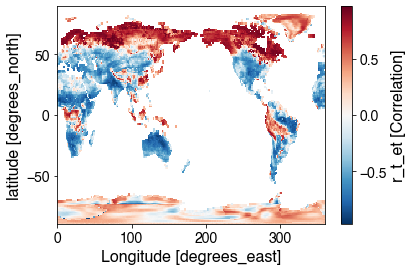

In [14]:
cmip6_rtet.r_t_et.plot()

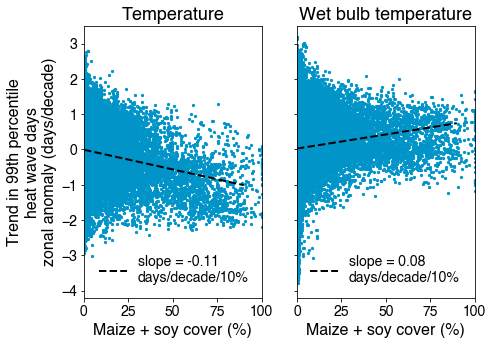

In [100]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7,5))

x1 = 0
x2 = 90

ax1.scatter(crop_ha_regrid_1d, trends_wave_days_t_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax1.plot([x1, x2], [mdl_wave_days_t_max.params[0], mdl_wave_days_t_max.params[0]+x2*mdl_wave_days_t_max.params[1]], '--k', lw=2, \
         label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_t_max.params[1]*10))
ax1.set_title('Temperature', fontsize=18)
ax1.set_xlabel('Maize + soy cover (%)')
ax1.set_ylabel('Trend in 99th percentile\nheat wave days\nzonal anomaly (days/decade)')
ax1.set_xlim([0, 100])
ax1.set_ylim([-4.2, 3.5])
ax1.legend(prop={'size': 14}, frameon=False)

ax2.scatter(crop_ha_regrid_1d, trends_wave_days_tw_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax2.plot([x1, x2], [mdl_wave_days_tw_max.params[0], mdl_wave_days_tw_max.params[0]+x2*mdl_wave_days_tw_max.params[1]], '--k', lw=2, \
        label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_tw_max.params[1]*10))
ax2.set_title('Wet bulb temperature', fontsize=18)
ax2.set_xlabel('Maize + soy cover (%)')
ax2.set_yticks(np.arange(-4, 3.1))
ax2.set_xlim([0, 100])
ax2.set_ylim([-4.2, 3.5])
ax2.legend(prop={'size': 14}, frameon=False)

# plt.savefig('figs/cropland-t-tw-zonal-mean-trends.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

# ax3.scatter(crop_ha_regrid_1d, trends_wave_days_t_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax3.plot([x1, x2], [mdl_wave_days_t_min.params[0], mdl_wave_days_t_min.params[0]+x2*mdl_wave_days_t_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_t_min.params[1]*10))
# ax3.set_title('T_min, q = %d'%q)
# ax3.set_xlabel('Crop cover (%)')
# ax3.set_ylabel('Cold wave days trend\nzonal anomaly\n(days/decade)')
# ax3.set_xlim([0, 100])
# # ax3.set_ylim([-4, 4])
# ax3.legend()

# ax4.scatter(crop_ha_regrid_1d, trends_wave_days_tw_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax4.plot([x1, x2], [mdl_wave_days_tw_min.params[0], mdl_wave_days_tw_min.params[0]+x2*mdl_wave_days_tw_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_tw_min.params[1]*10))
# ax4.set_title('TW_min, q = %d'%q)
# ax4.set_xlabel('Crop cover (%)')
# ax4.set_xlim([0, 100])
# # ax4.set_ylim([-4, 4])
# ax4.legend()


In [72]:
ind_no_crop = np.where((crop_ha_regrid_1d<=1))[0]
ind_low_crop = np.where((crop_ha_regrid_1d>1) & (crop_ha_regrid_1d<=25))[0]
ind_high_crop = np.where((crop_ha_regrid_1d>25))[0]

t_max_trend_no_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_no_crop, q])
t_max_trend_low_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_low_crop, q])
t_max_trend_high_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_high_crop, q])

tw_max_trend_no_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_no_crop, q])
tw_max_trend_low_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_low_crop, q])
tw_max_trend_high_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_high_crop, q])


print(t_max_trend_no_crop, t_max_trend_low_crop, t_max_trend_high_crop)
print(tw_max_trend_no_crop, tw_max_trend_low_crop, tw_max_trend_high_crop)

0.8347558764880052 0.9666224785926698 0.7906920555326428
0.7798830927907219 0.9551428739071759 1.1489443741759706
